In [1]:
# 필요 패키지 설치
!pip install factor_analyzer

In [2]:
# import
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm

from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [3]:
# 폰트 설치
!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
# 구글 드라이브에 있는 파일 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

# 데이터 로드
df = pd.read_csv('/content/gdrive/MyDrive/Main/final.csv', encoding='cp949')
industry_map = pd.read_excel('/content/gdrive/MyDrive/Main/중분류 11차.xlsx')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 데이터 확인

In [5]:
df.describe()

,industry_code,base_year_x,n_ent,avg_ent_wker,med_ent_wker,avg_ent_sls,med_ent_sls,avg_ent_tdwrkr,med_ent_tdwrkr,n_people,avg_age,med_age,avg_income,med_income,nominal_value_added,employment_thousand
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,2.980300e+04,29803.000000,29965.000000,29965.000000,29961.000000,29961.000000,29961.000000,2.996100e+04,2.996100e+04,2.996100e+04,29965.000000
mean,45.969898,20214.985617,6789.173603,71.228036,37.430878,1.326424e+04,1651.030012,15.747052,8.689054,25215.937851,45.325908,45.562171,3.986438e+07,3.352983e+07,6.127277e+07,541.901765
std,27.594112,17.446746,27785.452449,416.247698,241.535392,1.239464e+05,20324.562964,111.213692,64.620081,60550.798162,5.301198,6.690734,1.827980e+07,1.807911e+07,5.042097e+07,877.575106
min,1.000000,20184.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,28.320000,24.000000,4.000000e+05,4.000000e+05,1.737192e+06,0.000000
25%,23.000000,20201.000000,124.000000,4.980000,2.000000,2.847750e+02,44.500000,1.570000,0.500000,1541.000000,41.830000,41.000000,2.713022e+07,2.205000e+07,1.972011e+07,62.330000
50%,42.000000,20213.000000,734.000000,9.210000,3.000000,7.440200e+02,95.000000,2.500000,1.000000,5840.000000,44.910000,45.000000,3.662799e+07,2.943891e+07,4.411658e+07,222.780000
75%,68.000000,20231.000000,3394.000000,16.970000,4.500000,2.410445e+03,250.250000,4.340000,1.000000,21531.000000,48.390000,50.000000,4.793836e+07,3.995580e+07,9.565555e+07,712.420000
max,99.000000,20243.000000,579652.000000,14197.670000,5264.000000,5.509077e+06,850255.000000,6300.000000,2472.000000,688035.000000,64.530000,71.000000,1.512005e+08,1.631919e+08,2.031191e+08,6006.980000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sido                      29965 non-null  object 
 1   industry_code             29965 non-null  int64  
 2   base_year_x               29965 non-null  int64  
 3   n_ent                     29965 non-null  int64  
 4   avg_ent_wker              29965 non-null  float64
 5   med_ent_wker              29965 non-null  float64
 6   avg_ent_sls               29803 non-null  float64
 7   med_ent_sls               29803 non-null  float64
 8   avg_ent_tdwrkr            29965 non-null  float64
 9   med_ent_tdwrkr            29965 non-null  float64
 10  n_people                  29961 non-null  float64
 11  avg_age                   29961 non-null  float64
 12  med_age                   29961 non-null  float64
 13  avg_income                29961 non-null  float64
 14  med_in

## 데이터 전처리

In [7]:
# 1. 문자열 → 숫자(float)로 변환 + Nan -> 0
df['output_index'] = pd.to_numeric(df['output_index'], errors='coerce')
df['labor_productivity_index'] = pd.to_numeric(df['labor_productivity_index'], errors='coerce')

# 76번 산업에서 output_index 또는 labor_productivity_index가 0인 행들 찾기
target_mask = (
    (df["industry_code"] == 76) &
    ((df["output_index"] == 0) | (df["labor_productivity_index"] == 0))
)
target_rows = df[target_mask]

# 1. 원본 df에서 76번 산업 보정
for idx, row in df[(df["industry_code"] == 76) & ((df["output_index"] == 0) | (df["labor_productivity_index"] == 0))].iterrows():
    year_val = row["base_year_x"]
    sido_val = row["sido"]
    ref_row = df[(df["industry_code"] == 68) & (df["base_year_x"] == year_val) & (df["sido"] == sido_val)]
    if not ref_row.empty:
        if df.loc[idx, "output_index"] == 0:
            df.loc[idx, "output_index"] = ref_row.iloc[0]["output_index"]
        if df.loc[idx, "labor_productivity_index"] == 0:
            df.loc[idx, "labor_productivity_index"] = ref_row.iloc[0]["labor_productivity_index"]

# 나머지 결측치들을 0으로 변환
df.fillna(0, inplace=True)

# 2. 연도 및 분기 추출
df["year"] = df["base_year_x"] // 10
df["quarter"] = df["base_year_x"] % 10

#  3.정렬
df = df.sort_values(by=["sido", "industry_code", "base_year_x"]).reset_index(drop=True)

# 4. 전처리: 변화율 계산
yearly_cols = ["med_income", "avg_age", "n_people"]
halfly_cols = ["employment_thousand"]
quarterly_cols = ["n_ent", "med_ent_sls"]
for col in yearly_cols:
    df[f"{col}_yoy"] = df.groupby(["sido", "industry_code"])[col].pct_change(periods=4)
df["avg_age_yoy"] *= -1 # 중위 나이 증가율 방향 반전
for col in halfly_cols:
    df[f"{col}_hyoy"] = df.groupby(["sido", "industry_code"])[col].pct_change(periods=2)
for col in quarterly_cols:
    df[f"{col}_qoq"] = df.groupby(["sido", "industry_code"])[col].pct_change()

# 5. 전년도 증가율을 동일 연도 분기에 복사
for col in yearly_cols:
    col_yoy = f"{col}_yoy"
    for (sido, industry), group in df.groupby(["sido", "industry_code"]):
        group = group.sort_values("base_year_x")
        for year in sorted(group["year"].unique()):
            if year == 2018:
                continue
            this_year_idx = group[group["year"] == year].index
            prev_year_idx = group[group["year"] == (year - 1)].index
            if not prev_year_idx.empty and not this_year_idx.empty:
                prev_val = group.loc[prev_year_idx[-1], col]
                for idx in this_year_idx:
                    curr_val = group.loc[idx, col]
                    growth = (curr_val - prev_val) / prev_val if pd.notna(curr_val) and prev_val != 0 else None
                    df.loc[idx, col_yoy] = growth

# 6. DII 계산 대상 필터링 + NaN → 0,  (base_year_x == 20184인 행은 DII 계산에서 제거)
df_dii = df[df["base_year_x"] > 20184].copy()

## PCA & 사양산업지수


In [8]:
# 8. PCA 대상 변수 정의
group_columns = {
    "productivity": ["labor_productivity_index", "med_income_yoy"],
    "competitiveness": ["avg_age_yoy", "n_ent_qoq"],
    "market": ["employment_thousand_hyoy", "n_people_yoy"],
    "profit": ["med_ent_sls_qoq", "nominal_value_added"]
}

# 9. 이상값 처리 (무한대/NaN)
df_dii.replace([np.inf, -np.inf], 0, inplace=True)
df_dii.fillna(0, inplace=True)

# 10. Z-score 정규화 + 각 그룹별 PCA → score 도출
score_cols = []
for group, cols in group_columns.items():
    scaler = StandardScaler()
    z = scaler.fit_transform(df_dii[cols])

    for i, col in enumerate(cols):
        df_dii[f"{group}_z_{i}"] = z[:, i]

    pca = PCA(n_components=2)
    pc = pca.fit_transform(z)
    var1, var2 = pca.explained_variance_ratio_
    df_dii[f"{group}_score"] = pc[:, 0] * var1 + pc[:, 1] * var2
    score_cols.append(f"{group}_score")

# 11. 최종 DII 계산 (다시 PCA)
# 경쟁력 score 방향 반전
df_dii["competitiveness_score"] *= -1
scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(df_dii[score_cols])
pca_final = PCA(n_components=2)
pc_final = pca_final.fit_transform(X_scaled)
v1, v2 = pca_final.explained_variance_ratio_
df_dii["DII"] = pc_final[:, 0] * v1 + pc_final[:, 1] * v2

# 10. 저장
#df_dii.to_csv("/content/gdrive/MyDrive/Main/final_with_dii_and_zscore.csv", index=False, encoding="utf-8-sig")
print("✅ 최종 DII 계산 및 저장 완료: final_with_dii_and_zscore.csv")

✅ 최종 DII 계산 및 저장 완료: final_with_dii_and_zscore.csv


## 사양산업 분류

In [9]:
# 사양산업 여부 판단용 데이터프레임 복사
df_labeled = df_dii.copy()
df_labeled["is_declining"] = 0  # 초기화

# DII 하위 10% 기준값 계산
dii_cutoff = df_labeled["DII"].quantile(0.15) # 요 수치 수정 가능

# 지역-산업별로 사양산업 여부 판단
for (sido, industry), group in df_dii.groupby(["sido", "industry_code"]):
    group = group.sort_values("base_year_x")
    index_list = group.index.tolist()

    # 시계열 회귀 분석: 시간 축 생성
    X = sm.add_constant(range(len(group)))
    y = group["DII"].values
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # 기울기 추출

    # 3분기 연속 하락 여부 계산
    decline_seq = (group["DII"].diff() < 0).astype(int)
    rolling_decline = decline_seq.rolling(3).sum()

    # 조건 모두 만족 시 해당 시점에 1 할당
    for i in rolling_decline[rolling_decline == 3].index:
        if beta < 0 and group.loc[i, "DII"] <= dii_cutoff:
            df_labeled.loc[i, "is_declining"] = 1

# 위험도 측정(분위수 기반)
# 분위수 기준 설정
q10 = df_labeled["DII"].quantile(0.10)
q25 = df_labeled["DII"].quantile(0.25)
q75 = df_labeled["DII"].quantile(0.75)
q90 = df_labeled["DII"].quantile(0.90)

# 새로운 risk level 컬럼 생성
def classify_risk(dii):
    if dii <= q10:
        return "High Risk"
    elif dii <= q25:
        return "Risk"
    elif dii <= q75:
        return "Stable"
    elif dii <= q90:
        return "Growth"
    else:
        return "High Growth"

df_labeled["risk_level_5"] = df_labeled["DII"].apply(classify_risk)

# 결과 저장
#df_labeled.to_csv("/content/gdrive/MyDrive/Main/final_20_3.csv", index=False, encoding="utf-8-sig")
#print("✅ 사양산업 판단 완료 및 저장: final_with_dii_decline_label_full_series_filtered.csv")

# 전체 분기별 사양산업 라벨 분포 (0 / 1)
print("사양산업 여부 (분기 기준):")
print(df_labeled["is_declining"].value_counts())

bottom_10_count = (df_labeled["DII"] <= dii_cutoff).sum()
print(f"DII 하위 15%에 해당하는 분기 수: {bottom_10_count}개")

사양산업 여부 (분기 기준):
is_declining
0    28489
1      226
Name: count, dtype: int64
DII 하위 15%에 해당하는 분기 수: 4308개


In [10]:
# 산업코드별 집계
industry_grouped = df_labeled.groupby("industry_code").agg(
    decline_ratio=("is_declining", "mean"),
    avg_dii=("DII", "mean")
).reset_index()
industry_grouped["decline_ratio_percent"] = (industry_grouped["decline_ratio"] * 100).round(2)

# 지역별 집계
region_grouped = df_labeled.groupby("sido").agg(
    decline_ratio=("is_declining", "mean"),
    avg_dii=("DII", "mean")
).reset_index()
region_grouped["decline_ratio_percent"] = (region_grouped["decline_ratio"] * 100).round(2)

# 결과 출력
print("📊 산업코드별 사양산업 비중 (%) 및 평균 DII:")
print(industry_grouped)

print("\n📊 지역별 사양산업 비중 (%) 및 평균 DII:")
print(region_grouped)

📊 산업코드별 사양산업 비중 (%) 및 평균 DII:
    industry_code  decline_ratio   avg_dii  decline_ratio_percent
0               1       0.000000 -0.000558                   0.00
1               2       0.000000 -0.009458                   0.00
2               3       0.000000  0.027107                   0.00
3               5       0.000000 -0.005793                   0.00
4               6       0.011236  0.052985                   1.12
..            ...            ...       ...                    ...
71             94       0.000000 -0.022466                   0.00
72             95       0.000000  0.005744                   0.00
73             96       0.000000 -0.002352                   0.00
74             97       0.000000  0.018971                   0.00
75             99       0.000000  0.069469                   0.00

[76 rows x 4 columns]

📊 지역별 사양산업 비중 (%) 및 평균 DII:
       sido  decline_ratio   avg_dii  decline_ratio_percent
0       강원도       0.013435  0.001005                   1.34
1     

## 통계적 검정

### KMO, Bartlett’s Test

In [11]:
group_columns_z = {
    "productivity": ["labor_productivity_index", "med_income"],
    "competitiveness": ["avg_age", "n_ent"],
    "market": ["employment_thousand", "n_people"],
    "profit": ["med_ent_sls", "nominal_value_added"]
}

score_cols = ['productivity_score', 'competitiveness_score', 'market_score', 'profit_score']

# 2. Z-score 정규화된 원본 변수 데이터프레임 생성
scaler = StandardScaler()
df_pca_z_scaled = pd.DataFrame(scaler.fit_transform(df_dii[sum(group_columns_z.values(), [])]),
                               columns=sum(group_columns_z.values(), []))

# 3. 그룹별 KMO & Bartlett’s Test
group_results = {}
for group, cols in group_columns_z.items():
    sub_df = df_pca_z_scaled[cols]
    kmo_all, kmo_val = calculate_kmo(sub_df)
    _, p_val = calculate_bartlett_sphericity(sub_df)
    group_results[group] = {
        "KMO": round(kmo_val, 3),
        "Bartlett_p": round(p_val, 5)
    }

# 4. DII (4개 그룹 score → 최종 지수) 적합성 검정
df_scores_z = pd.DataFrame(scaler.fit_transform(df_dii[score_cols]), columns=score_cols)
kmo_dii_all, kmo_dii_val = calculate_kmo(df_scores_z)
_, pval_dii = calculate_bartlett_sphericity(df_scores_z)

group_results["DII(4 scores)"] = {
    "KMO": round(kmo_dii_val, 3),
    "Bartlett_p": round(pval_dii, 5)
}

# 5. 결과 출력
for group, res in group_results.items():
    print(f"📌 [{group}]")
    print(f"  - KMO: {res['KMO']:.3f}")
    print(f"  - Bartlett’s Test p-value: {res['Bartlett_p']:.3f}\n")

📌 [productivity]
  - KMO: 0.500
  - Bartlett’s Test p-value: 0.000

📌 [competitiveness]
  - KMO: 0.500
  - Bartlett’s Test p-value: 0.000

📌 [market]
  - KMO: 0.500
  - Bartlett’s Test p-value: 0.000

📌 [profit]
  - KMO: 0.500
  - Bartlett’s Test p-value: 0.000

📌 [DII(4 scores)]
  - KMO: 0.506
  - Bartlett’s Test p-value: 0.000



In [12]:
from IPython.display import display

# Bartlett’s Test 결과만 추출
bartlett_results = {
    group: res["Bartlett_p"]
    for group, res in group_results.items()
}

# 데이터프레임으로 변환
bartlett_df = pd.DataFrame.from_dict(bartlett_results, orient="index", columns=["Bartlett's Test p-value"])
bartlett_df.index.name = "Group"

# 표 출력
display(bartlett_df)

,Bartlett's Test p-value
Group,
productivity,0.0
competitiveness,0.0
market,0.0
profit,0.0
DII(4 scores),0.0


### 상관관계 히트맵

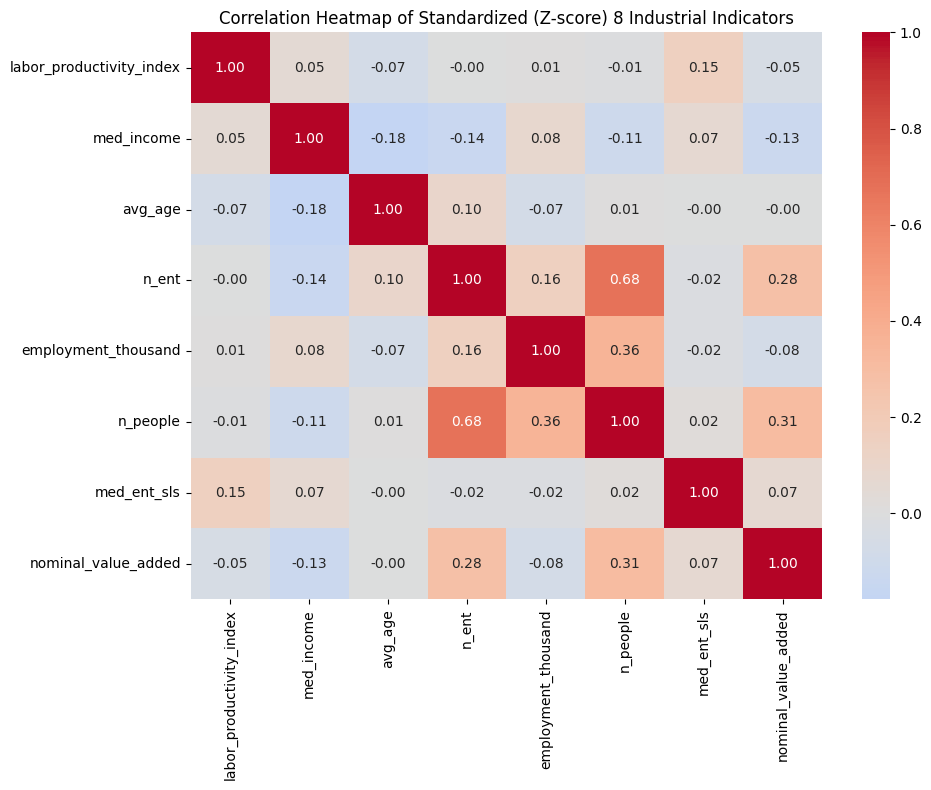

In [13]:
# 6. 전체 8개 변수에 대한 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(df_pca_z_scaled.corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Standardized (Z-score) 8 Industrial Indicators")
plt.tight_layout()
plt.show()

### 다중공선성 검정 (VIF)

In [14]:
# VIF: Variance Inflation Factor - 다중공선성 여부 파악
# 각 변수 간 선형 결합성 여부를 수치로 평가
# 기준: VIF > 5: 중간 수준 이상 다중공선성, VIF > 10: 매우 심각한 다중공선성
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF 계산용 데이터프레임
X = df_pca_z_scaled.copy()  # 8개 Z-score 변수 사용

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_data)

                   Variable       VIF
0  labor_productivity_index  1.034382
1                med_income  1.077230
2                   avg_age  1.055767
3                     n_ent  1.920925
4       employment_thousand  1.234144
5                  n_people  2.237700
6               med_ent_sls  1.039059
7       nominal_value_added  1.183201


### 설명 분산 비율 확인

In [15]:
from sklearn.decomposition import PCA

# PCA 대상 변수: Z-score 정규화된 8개 변수
X_z = df_pca_z_scaled.copy()

# PCA 수행
pca = PCA()
pca.fit(X_z)

# 설명 분산 비율
explained_var_ratio = pca.explained_variance_ratio_

# 누적 설명 분산
cumulative_var_ratio = explained_var_ratio.cumsum()

# 출력
for i, (evr, cum) in enumerate(zip(explained_var_ratio, cumulative_var_ratio), start=1):
    print(f"PC{i}: 설명 분산 비율 = {evr:.4f}, 누적 = {cum:.4f}")

PC1: 설명 분산 비율 = 0.2512, 누적 = 0.2512
PC2: 설명 분산 비율 = 0.1639, 누적 = 0.4150
PC3: 설명 분산 비율 = 0.1436, 누적 = 0.5586
PC4: 설명 분산 비율 = 0.1236, 누적 = 0.6823
PC5: 설명 분산 비율 = 0.1093, 누적 = 0.7916
PC6: 설명 분산 비율 = 0.0956, 누적 = 0.8872
PC7: 설명 분산 비율 = 0.0780, 누적 = 0.9651
PC8: 설명 분산 비율 = 0.0349, 누적 = 1.0000


In [16]:
group_columns_z = {
    "productivity": ["labor_productivity_index", "med_income"],
    "competitiveness": ["avg_age", "n_ent"],
    "market": ["employment_thousand", "n_people"],
    "profit": ["med_ent_sls", "nominal_value_added"]
}

# 각 항목별 PCA 분석 결과 출력
for group, cols in group_columns_z.items():
    print(f"\n📊 [PCA 결과: {group}]")

    # Z-score 정규화
    scaler = StandardScaler()
    X = scaler.fit_transform(df_dii[cols])

    # PCA 수행
    pca = PCA()
    pca.fit(X)

    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var_ratio = explained_var_ratio.cumsum()

    for i, (evr, cum) in enumerate(zip(explained_var_ratio, cumulative_var_ratio), start=1):
        print(f"  PC{i}: 설명 분산 비율 = {evr:.4f}, 누적 = {cum:.4f}")


📊 [PCA 결과: productivity]
  PC1: 설명 분산 비율 = 0.5261, 누적 = 0.5261
  PC2: 설명 분산 비율 = 0.4739, 누적 = 1.0000

📊 [PCA 결과: competitiveness]
  PC1: 설명 분산 비율 = 0.5500, 누적 = 0.5500
  PC2: 설명 분산 비율 = 0.4500, 누적 = 1.0000

📊 [PCA 결과: market]
  PC1: 설명 분산 비율 = 0.6790, 누적 = 0.6790
  PC2: 설명 분산 비율 = 0.3210, 누적 = 1.0000

📊 [PCA 결과: profit]
  PC1: 설명 분산 비율 = 0.5329, 누적 = 0.5329
  PC2: 설명 분산 비율 = 0.4671, 누적 = 1.0000


### 변수 기여율 확인

In [17]:
## 전체 변수 -> 사양산업지수

# 대상 변수 정리
target_vars = sum(group_columns.values(), [])
X = df_dii[target_vars]

# Z-score 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 수행
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_

# 요인 부하량 계산
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=["PC1", "PC2"])

# 절댓값 기준 기여율 비중 계산 (%)
loadings["contribution_PC1(%)"] = abs(loadings["PC1"]) * explained[0] * 100
loadings["contribution_PC2(%)"] = abs(loadings["PC2"]) * explained[1] * 100
loadings["total_contribution(%)"] = loadings["contribution_PC1(%)"] + loadings["contribution_PC2(%)"]

# 정렬해서 출력
loadings_sorted = loadings.sort_values("total_contribution(%)", ascending=False)
loadings_sorted = loadings_sorted[["contribution_PC1(%)", "contribution_PC2(%)", "total_contribution(%)"]]
loadings_sorted

,contribution_PC1(%),contribution_PC2(%),total_contribution(%)
nominal_value_added,2.629348,9.668713,12.298061
n_people_yoy,9.458892,1.216597,10.675489
med_income_yoy,7.656739,2.203696,9.860434
avg_age_yoy,5.977334,2.703962,8.681296
labor_productivity_index,3.833979,3.333707,7.167687
employment_thousand_hyoy,0.906444,5.188901,6.095345
med_ent_sls_qoq,0.794699,5.038002,5.832701
n_ent_qoq,2.349764,2.400129,4.749893


In [18]:
## 영역별 변수 -> 사양산업지수

# DII 계산에 사용한 PCA 객체로 부하량 계산
loadings = pd.DataFrame(pca_final.components_.T, index=score_cols, columns=["PC1", "PC2"])

# 절댓값 기준 기여율 비중 계산 (%)
loadings["contribution_PC1(%)"] = abs(loadings["PC1"]) * v1 * 100
loadings["contribution_PC2(%)"] = abs(loadings["PC2"]) * v2 * 100
loadings["total_contribution(%)"] = loadings["contribution_PC1(%)"] + loadings["contribution_PC2(%)"]

# 정렬 후 출력
loadings_sorted = loadings.sort_values("total_contribution(%)", ascending=False)
print(loadings_sorted[["contribution_PC1(%)", "contribution_PC2(%)", "total_contribution(%)"]])

                       contribution_PC1(%)  contribution_PC2(%)  \
market_score                     16.305844            10.398368   
productivity_score               10.799543            14.425936   
profit_score                      7.691578            17.412327   
competitiveness_score            17.563105             6.842050   

                       total_contribution(%)  
market_score                       26.704212  
productivity_score                 25.225479  
profit_score                       25.103905  
competitiveness_score              24.405154  


### 구조방정식

In [19]:
# 구조방정식 모형으로 검증
!pip install semopy

In [20]:
from semopy import Model, Optimizer
from semopy.inspector import inspect

# 사용할 변수들
sem_vars = [
    "productivity_z_0", "productivity_z_1",
    "competitiveness_z_0", "competitiveness_z_1",
    "market_z_0", "market_z_1",
    "profit_z_0", "profit_z_1",
    "DII"
]

# 결측치 제거
df_sem = df_dii[sem_vars].dropna()

# SEM 모형 정의
model_desc = """
# 잠재변수 정의
productivity =~ productivity_z_0 + productivity_z_1
competitiveness =~ competitiveness_z_0 + competitiveness_z_1
market =~ market_z_0 + market_z_1
profit =~ profit_z_0 + profit_z_1

# 최종 종속 변수 DII에 대한 회귀식
DII ~ productivity + competitiveness + market + profit
"""

# 모델 학습
model = Model(model_desc)
model.fit(df_sem)

# 1. 회귀 계수 및 유의성
#print("📊 회귀 계수 및 유의성:")
#display(inspect(model))

SolverResult(fun=np.float64(0.06077149916361346), success=np.True_, n_it=191, x=array([ 1.62465477e-02, -3.48070476e-03, -8.44400118e+01,  8.61482715e-02,
        2.48351378e-01, -1.06067250e-01, -4.94642188e+00,  2.60307392e-01,
        8.35362304e-15,  1.00003081e+00,  0.00000000e+00,  9.99979157e-01,
        1.39867692e-04,  9.38075081e-04,  9.99994986e-01,  0.00000000e+00,
        9.99906307e-01, -2.54956381e-02, -1.65372916e-04,  0.00000000e+00,
        9.99725999e-01,  9.53217805e-01, -1.46915106e-02, -2.19552080e-05,
        4.97857035e-02,  4.68667262e-02,  9.92920293e-01]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW')

### Cronbach’s α 값 검정

In [21]:
from scipy.stats import zscore

# Cronbach’s α 계산 함수
def cronbach_alpha(df_subset):
    df_clean = df_subset.dropna()
    item_vars = df_clean.var(axis=0, ddof=1)
    total_var = df_clean.sum(axis=1).var(ddof=1)
    k = df_clean.shape[1]
    return (k / (k - 1)) * (1 - item_vars.sum() / total_var)

# 영역별 변수 정의
variable_groups = {
    "productivity": ["labor_productivity_index", "med_income_yoy"],
    "competitiveness": ["avg_age_yoy", "n_ent_qoq"],
    "market": ["employment_thousand", "n_people_yoy"],
    "profit": ["med_ent_sls_qoq", "nominal_value_added"]
}

# 결과 저장
final_alpha_dii_results = []

# 각 영역에 대해 Cronbach’s α 및 DII와의 상관계수 계산
for domain, vars in variable_groups.items():
    # Z-score 정규화
    z_subset = df_labeled[vars].apply(zscore).dropna()

    # Cronbach’s α 계산
    alpha = cronbach_alpha(z_subset)

    # DII와 해당 영역 score와의 상관계수 계산
    domain_score = df_labeled[f"{domain}_score"]
    corr = df_labeled["DII"].corr(domain_score)

    # 결과 저장
    final_alpha_dii_results.append({
        "영역": domain,
        "Cronbach’s α (Z-score 기준)": round(alpha, 4),
        "DII와의 상관계수 (ρ)": round(corr, 4)
    })

# 결과를 데이터프레임으로 정리
final_alpha_dii_df = pd.DataFrame(final_alpha_dii_results)

# 출력
print(final_alpha_dii_df)

                영역  Cronbach’s α (Z-score 기준)  DII와의 상관계수 (ρ)
0     productivity                     0.0320          0.6878
1  competitiveness                    -0.0069          0.3134
2           market                    -0.0784          0.1834
3           profit                     0.0830          0.6796


### 외적 타당도 분석 - 피어슨 상관계수

In [22]:
# 피어슨 상관계수 계산
correlation = df_labeled[score_cols + ['DII']].corr(method="pearson")["DII"].drop("DII").sort_values(ascending=False)

# 보기 좋게 데이터프레임으로 정리
correlation_df = correlation.reset_index()
correlation_df.columns = ["영역", "DII와의 상관계수 (ρ)"]

# 출력
print(correlation_df)

                      영역  DII와의 상관계수 (ρ)
0     productivity_score        0.687839
1           profit_score        0.679563
2  competitiveness_score        0.313400
3           market_score        0.183449


## 시각화

/tmp/ipython-input-23-3902653453.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts_named.index, y=industry_counts_named.values, palette="Blues_d")
/tmp/ipython-input-23-3902653453.py:22: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-23-3902653453.py:22: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-23-3902653453.py:22: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-23-3902653453.py:22: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-23-3902653453.py:22: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missin

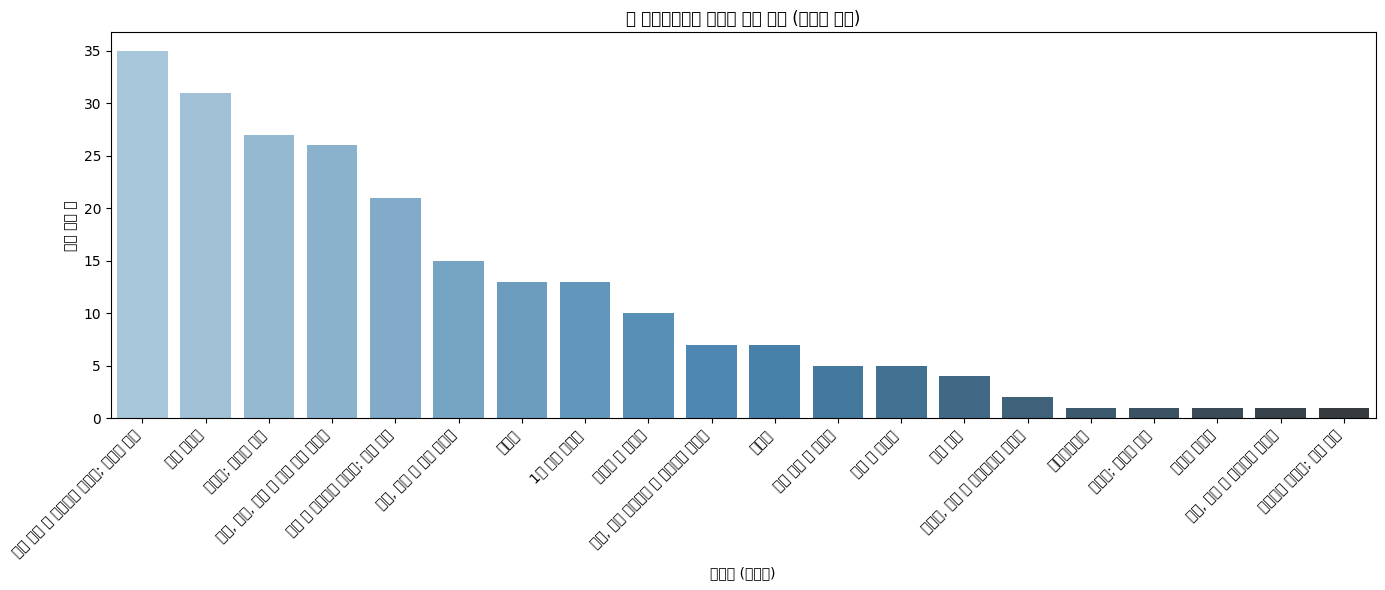

In [23]:
#  DII 하위 10% 산업 강조	산업코드 분포 막대그래프 어떤 산업이 사양 분류에 많이 포함됐는지

# 산업코드-산업명 매핑
industry_map = dict(zip(industry_map["코드"], industry_map["항목명"]))

# 사양산업만 필터링
declining_df = df_labeled[df_labeled["is_declining"] == 1]

# 산업코드별 사양산업 분기 수 집계
industry_counts = declining_df["industry_code"].value_counts()

# 코드 → 산업명으로 매핑
industry_counts_named = industry_counts.rename(index=industry_map)

# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(x=industry_counts_named.index, y=industry_counts_named.values, palette="Blues_d")
plt.title("📉 사양산업으로 분류된 산업 분포 (산업명 기준)")
plt.xlabel("산업명 (중분류)")
plt.ylabel("사양 분기 수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/tmp/ipython-input-24-4032020453.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_named.index, y=high_risk_named.values, palette="Reds")
/tmp/ipython-input-24-4032020453.py:17: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-24-4032020453.py:17: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-24-4032020453.py:17: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-24-4032020453.py:17: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-24-4032020453.py:17: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) D

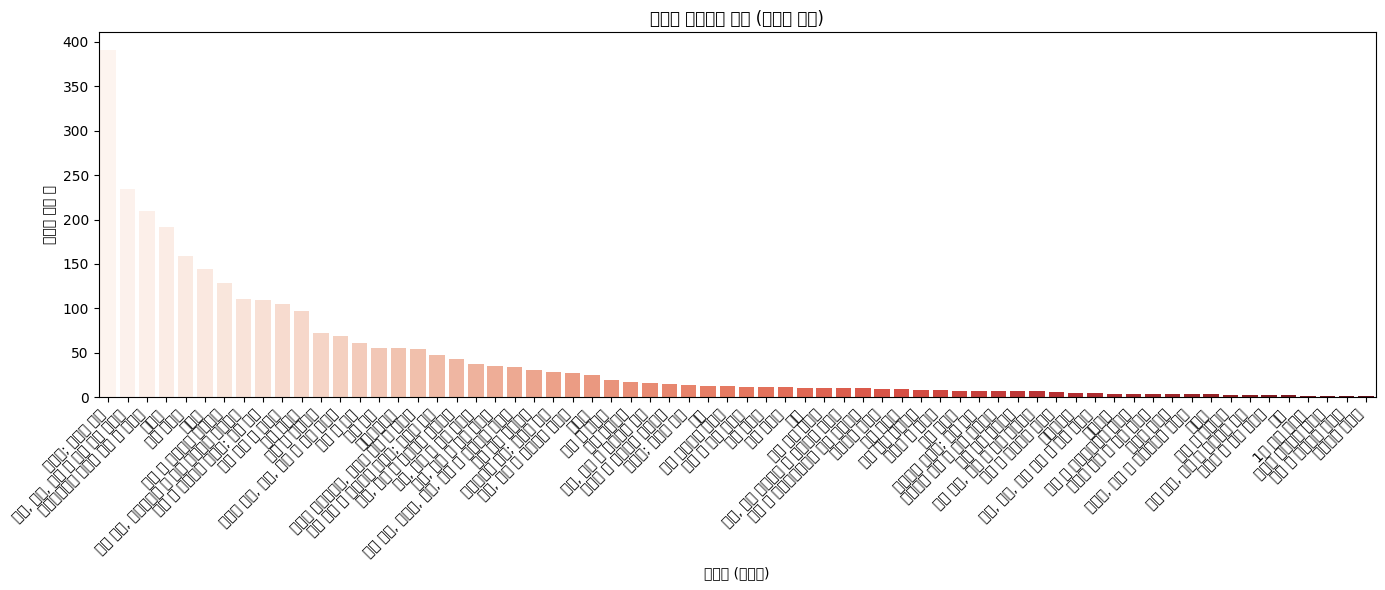

,산업명(중분류),고위험 분기 수
0,임대업; 부동산 제외,391
1,"전기, 가스, 증기 및 공기 조절 공급업",234
2,영상ㆍ오디오 기록물 제작 및 배급업,210
3,출판업,192
4,가구 제조업,159


In [24]:
# 고위험 사양산업만 필터링
high_risk_df = df_labeled[df_labeled["risk_level_5"] == "High Risk"]

# 산업코드별 고위험 분기 수 집계
high_risk_counts = high_risk_df["industry_code"].value_counts()

# 산업코드 → 산업명 매핑
high_risk_named = high_risk_counts.rename(index=industry_map)

# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(x=high_risk_named.index, y=high_risk_named.values, palette="Reds")
plt.title("고위험 사양산업 분포 (산업명 기준)")
plt.xlabel("산업명 (중분류)")
plt.ylabel("고위험 분기 수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

top5_high_risk = high_risk_named.head(5).reset_index()
top5_high_risk.columns = ['산업명(중분류)', '고위험 분기 수']

# 표 출력
import pandas as pd
import IPython.display as display

display.display(top5_high_risk)

/tmp/ipython-input-25-3029692465.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_named.index, y=high_risk_named.values, palette="Reds")
/tmp/ipython-input-25-3029692465.py:18: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-3029692465.py:18: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-3029692465.py:18: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-3029692465.py:18: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-3029692465.py:18: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) Deja

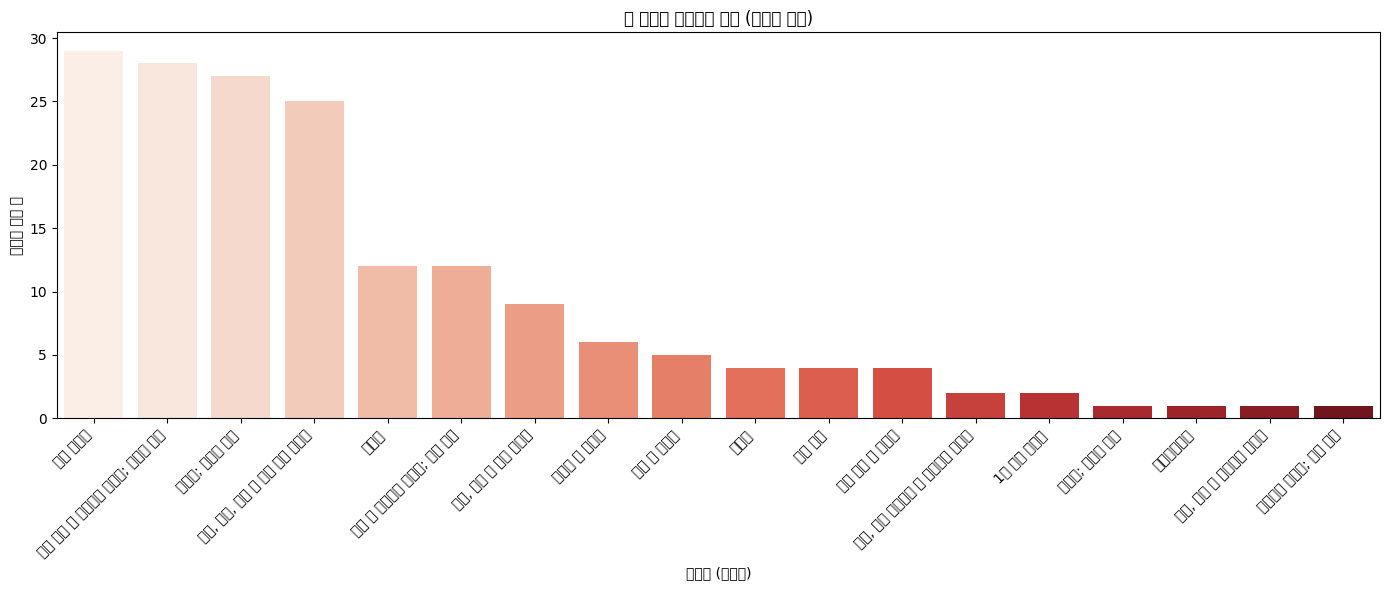

,산업명(중분류),고위험 분기 수
0,가구 제조업,29
1,화학 물질 및 화학제품 제조업; 의약품 제외,28
2,임대업; 부동산 제외,27
3,"전기, 가스, 증기 및 공기 조절 공급업",25
4,수도업,12


In [25]:
# 1. 고위험 사양산업 필터링
high_risk_df = df_labeled[(df_labeled["risk_level_5"] == "High Risk") & (df_labeled["is_declining"] == 1)]

# 2. 산업코드별 고위험 분기 수 집계
high_risk_counts = high_risk_df["industry_code"].value_counts().sort_values(ascending=False)

# 3. 산업코드 → 산업명 매핑 (industry_map: 예 {76: "섬유업", 88: "자동차제조업", ...})
# 매핑이 안 된 경우에는 코드 그대로 유지
high_risk_named = high_risk_counts.rename(index=lambda x: industry_map.get(x, str(x)))

# 4. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(x=high_risk_named.index, y=high_risk_named.values, palette="Reds")
plt.title("🔴 고위험 사양산업 분포 (산업명 기준)")
plt.xlabel("산업명 (중분류)")
plt.ylabel("고위험 분기 수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 5. 상위 5개 표 형태 출력
top5_high_risk = high_risk_named.head(5).reset_index()
top5_high_risk.columns = ['산업명(중분류)', '고위험 분기 수']

from IPython.display import display
display(top5_high_risk)
